# Initialization

In [1]:
%%capture
!pip install geopandas

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, DecimalType, IntegerType, StructType, StructField, StringType
from pyspark.sql.functions import col, month, year, isnan, desc, unix_timestamp, to_timestamp, dayofmonth, hour, minute, second
from functools import reduce
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /scratch/hradhakrishnan/job_30430147/matplotlib-7n1c4arc because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# Setting up a theme with Seaborn
sns.set_theme(style="whitegrid")

# Adjusting font scale for better readability
sns.set_context("notebook", font_scale=1.2)

In [4]:
# Create a Spark session
# spark = SparkSession.builder \
#     .appName("Yellow Taxi EDA") \
#     .getOrCreate()


# I ran this notebook successfully using 4 cores and 8GB per node in the jupyter session setup. 
# Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting.
spark = SparkSession.builder \
    .config("spark.driver.memory", "32g") \
	.config("spark.executor.memory", "4g") \
    .config('spark.executor.instances', 6) \
	.appName("Yellow Taxi EDA") \
	.getOrCreate()

In [5]:
spark

# Importing Data

In [6]:
base_path = 'yellow_taxi_data/yellow_tripdata_2023-{:02d}.parquet'

paths=[]
for mo in range(1, 7):  # This loops from 1 to 12
    path = base_path.format(mo)  # Formats the month with leading zero if necessary
    paths.append(path)

# paths = ['yellow_taxi_data/yellow_tripdata_2023-01.parquet', 'yellow_taxi_data/yellow_tripdata_2023-02.parquet']

In [7]:
# spark.read.parquet('yellow_taxi_data/yellow_tripdata_2023-01.parquet')

In [8]:
# Function to load and cast a single Parquet file
def load_and_cast(filepath):
    df = spark.read.parquet(filepath)
    df = df.withColumn("VendorID", col("VendorID").cast(IntegerType()))
    return df

# Load, cast, and accumulate all DataFrames
dataframes = [load_and_cast(path) for path in paths]
df = reduce(lambda df1, df2: df1.unionByName(df2), dataframes)

# Show the DataFrame
df.show(1)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

In [9]:
df.count()

19493620

In [10]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



# EDA 

In [11]:
# Summary statistics for numeric fields
numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount']
df.select(numeric_cols).describe().show()

+-------+------------------+------------------+------------------+-----------------+-----------------+
|summary|   passenger_count|     trip_distance|       fare_amount|       tip_amount|     total_amount|
+-------+------------------+------------------+------------------+-----------------+-----------------+
|  count|          18965068|          19493620|          19493620|         19493620|         19493620|
|   mean|1.3629848308479569| 4.080598819510947|19.154405136142593|3.499121566954948|28.04725801254911|
| stddev| 0.892183932044041|249.64444355975652|  89.5893771550846|4.020777372772306|90.65430877134082|
|    min|               0.0|               0.0|            -959.9|           -411.0|          -982.95|
|    max|               9.0|         342344.85|         386983.63|            984.3|        386987.63|
+-------+------------------+------------------+------------------+-----------------+-----------------+



In [12]:
# Dictionary to hold the column names and their corresponding counts of missing values
missing_counts = {}

# Calculate missing values for each column, taking data type into consideration
for col_name in df.columns:
    if df.schema[col_name].dataType == "DoubleType" or df.schema[col_name].dataType == "FloatType":
        missing_count = df.filter((col(col_name).isNull()) | (isnan(col_name))).count()
    else:
        missing_count = df.filter(col(col_name).isNull()).count()
    missing_counts[col_name] = missing_count

# Convert the dictionary to a Pandas DataFrame for displaying as a table
missing_counts_df = pd.DataFrame(list(missing_counts.items()), columns=['Column Name', 'Missing Values'])

# Display the DataFrame as a table
print(missing_counts_df)

              Column Name  Missing Values
0                VendorID               0
1    tpep_pickup_datetime               0
2   tpep_dropoff_datetime               0
3         passenger_count          528552
4           trip_distance               0
5              RatecodeID          528552
6      store_and_fwd_flag          528552
7            PULocationID               0
8            DOLocationID               0
9            payment_type               0
10            fare_amount               0
11                  extra               0
12                mta_tax               0
13             tip_amount               0
14           tolls_amount               0
15  improvement_surcharge               0
16           total_amount               0
17   congestion_surcharge          528552
18            airport_fee          528552


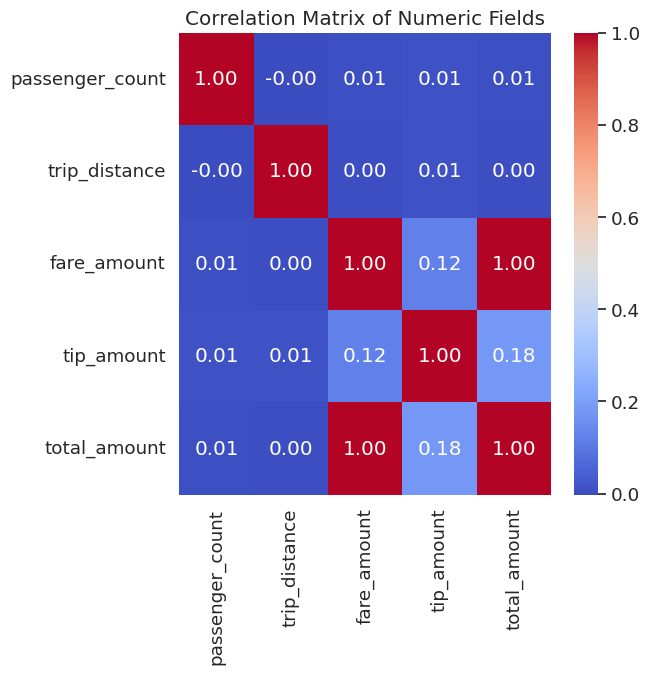

In [13]:
correlation_matrix = pd.DataFrame(index=numeric_cols, columns=numeric_cols)

for col1 in numeric_cols:
    for col2 in numeric_cols:
        corr_value = df.stat.corr(col1, col2)
        correlation_matrix.loc[col1, col2] = corr_value

# Convert entries from object to float for plotting
correlation_matrix = correlation_matrix.astype(float)

# Plotting the correlation matrix
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numeric Fields')
plt.show()

In [14]:
# Most common values for categorical fields
categorical_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type']
for col_name in categorical_cols:
    df.groupBy(col_name).count().orderBy(desc("count")).show()

+--------+--------+
|VendorID|   count|
+--------+--------+
|       2|14242526|
|       1| 5245998|
|       6|    5096|
+--------+--------+

+----------+--------+
|RatecodeID|   count|
+----------+--------+
|       1.0|17925280|
|       2.0|  750333|
|      NULL|  528552|
|       5.0|   96844|
|      99.0|   95158|
|       3.0|   63642|
|       4.0|   33782|
|       6.0|      29|
+----------+--------+

+------------------+--------+
|store_and_fwd_flag|   count|
+------------------+--------+
|                 N|18854960|
|              NULL|  528552|
|                 Y|  110108|
+------------------+--------+

+------------+------+
|PULocationID| count|
+------------+------+
|         132|993524|
|         237|920499|
|         161|893743|
|         236|831315|
|         162|682956|
|         186|658093|
|         138|653381|
|         142|645180|
|         230|643242|
|         170|575098|
|         163|563951|
|         239|546406|
|          48|526753|
|         234|526540|
|        

In [15]:
def filter_quantile_range(df, col_names, lower_quantile=0.01, upper_quantile=0.99):
    """
    Filter data in the DataFrame based on the specified quantile range for given columns.

    Parameters:
        df (DataFrame): The input DataFrame to filter.
        col_names (list): List of column names to filter on.
        lower_quantile (float): The lower quantile bound (e.g., 0.1 for the 10th percentile).
        upper_quantile (float): The upper quantile bound (e.g., 0.9 for the 90th percentile).

    Returns:
        DataFrame: The filtered DataFrame within the specified quantile range.
    """
    # Initialize an empty list to store the filter conditions
    conditions = []
    
    for column_name in col_names:
        # Get the quantile bounds for the column
        lower_bound, upper_bound = df.approxQuantile(column_name, [lower_quantile, upper_quantile], 0.01)
        
        # Create a condition to filter data within the quantile range for this column
        condition = (col(column_name) >= lower_bound) & (col(column_name) <= upper_bound)
        conditions.append(condition)
    
    # Combine all the conditions using AND (every column must meet its own condition)
    combined_condition = conditions[0]
    for condition in conditions[1:]:
        combined_condition &= condition
    
    # Filter the DataFrame based on the combined condition
    filtered_df = df.filter(combined_condition)
    
    return filtered_df

In [16]:
# Sampling a fraction of the data for visualization
sampled_df = df.sample(fraction=0.1, withReplacement=False)

In [17]:
sampled_df.cache()

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: double, trip_distance: double, RatecodeID: double, store_and_fwd_flag: string, PULocationID: bigint, DOLocationID: bigint, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, airport_fee: double]

## 1. Total Amount/ Fare Amount/ Tip Amount

In [18]:
pandas_df = sampled_df.select("total_amount", "tip_amount", "fare_amount").toPandas()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_com

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=pandas_df, color='blue', size=2, alpha=0.6)
plt.title('Scatter Plot of Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.show()

### Analysis of negative fare and tip amounts

In [ ]:
# Filter for negative fares and tips, group by payment type
negative_fares_tips = sampled_df.filter((col("fare_amount") < 0) | (col("tip_amount") < 0))

In [ ]:
negative_fares_tips.groupBy("payment_type").count().show()

In [ ]:
# Group by RateCodeID for entries with negative fares or tips
negative_fares_tips.groupBy("RateCodeID").count().show()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [32]:
# Extract year and month, then analyze counts of negative values
negative_fares_tips.withColumn("year", year("tpep_pickup_datetime")) \
    .withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("year", "month").count().orderBy("year", "month").show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2023|    1| 2572|
|2023|    2| 2469|
|2023|    3| 2903|
|2023|    4| 2910|
|2023|    5| 3178|
|2023|    6| 3103|
+----+-----+-----+



### Filter outliers based on quantiles

In [34]:
filtered_df = filter_quantile_range(sampled_df, ["total_amount", "tip_amount", "fare_amount"], lower_quantile=0.05, upper_quantile=0.95)

In [35]:
filtered_pandas_df = filtered_df.select("total_amount", "tip_amount", "fare_amount").toPandas()

In [36]:
filtered_pandas_df

,total_amount,tip_amount,fare_amount
0,64.44,10.74,45.70
1,37.32,6.22,26.10
2,28.60,6.60,17.00
3,26.62,5.32,16.30
4,55.50,11.10,39.40
...,...,...,...
1679318,48.25,8.04,36.21
1679319,36.73,2.40,30.33
1679320,33.10,3.01,26.09
1679321,38.83,0.00,34.83


In [38]:
filtered_pandas_df.describe()

,total_amount,tip_amount,fare_amount
count,1.679323e+06,1.679323e+06,1.679323e+06
mean,2.400464e+01,2.928147e+00,1.604013e+01
std,1.158422e+01,2.302560e+00,9.521597e+00
min,1.120000e+01,0.000000e+00,5.800000e+00
25%,1.630000e+01,1.000000e+00,9.300000e+00
50%,2.052000e+01,2.850000e+00,1.316000e+01
75%,2.770000e+01,4.080000e+00,1.910000e+01
max,8.180000e+01,1.130000e+01,6.390000e+01


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


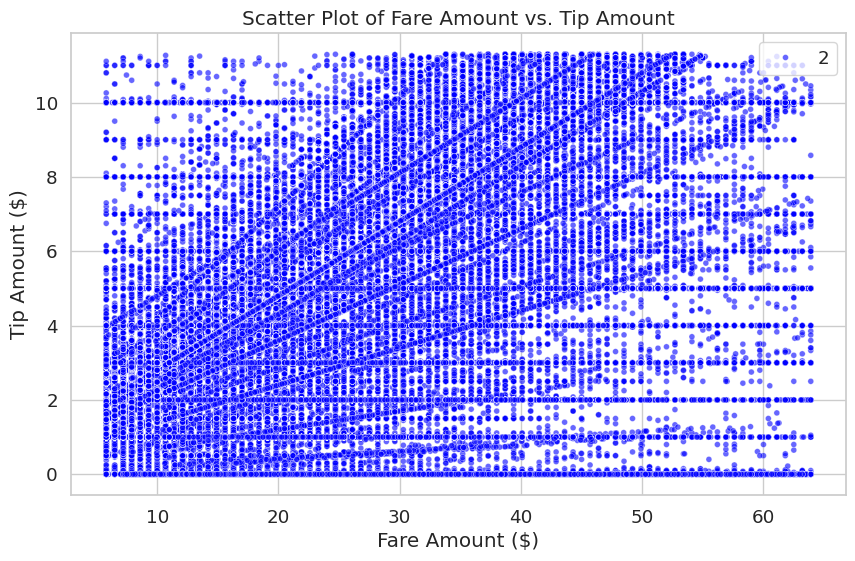

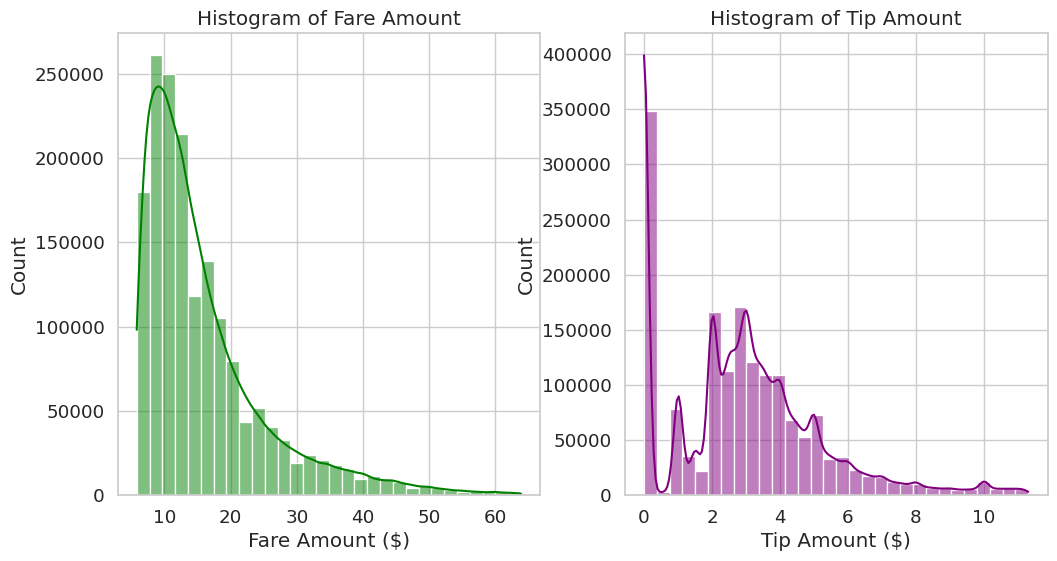

In [37]:
# Scatter plot to observe the relationship between fare amount and tip amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=filtered_pandas_df, color='blue', size=2, alpha=0.6)
plt.title('Scatter Plot of Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.show()

# Histograms to view the distributions of fare amount and tip amount
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(filtered_pandas_df['fare_amount'], kde=True, bins=30, color='green')
plt.title('Histogram of Fare Amount')
plt.xlabel('Fare Amount ($)')

plt.subplot(1, 2, 2)
sns.histplot(filtered_pandas_df['tip_amount'], kde=True, bins=30, color='purple')
plt.title('Histogram of Tip Amount')
plt.xlabel('Tip Amount ($)')
plt.show()

In [17]:
# if, even after filtering based on quantiles there are some negative fare/ tip amounts, we can filter those
# filtered_pandas_df = filtered_pandas_df[(pandas_df['fare_amount']>0) & (pandas_df['tip_amount']>0)]

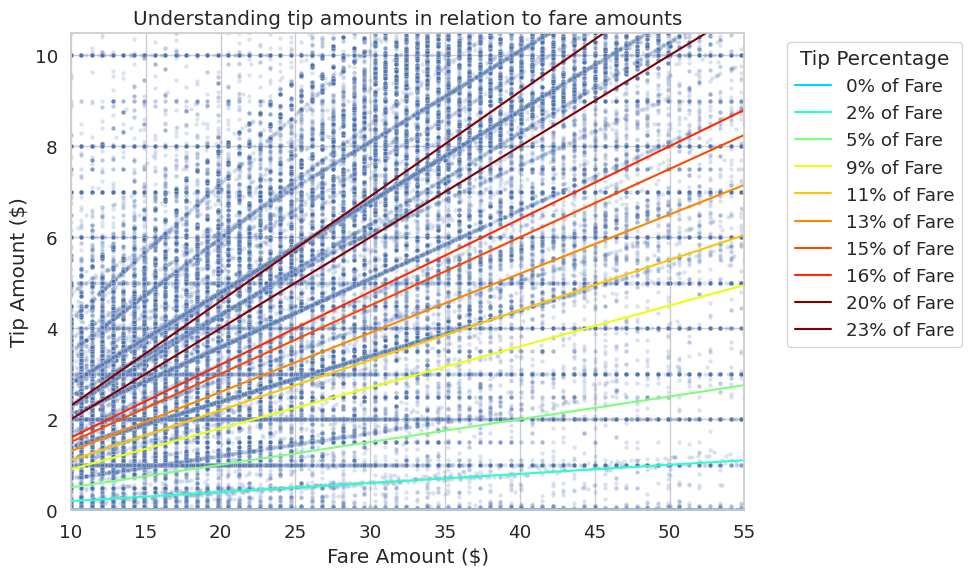

In [48]:
# Understanding tip amounts in relation to fare amounts
slopes = [0,2,5,9,11,13,15, 16,20, 23]
x_val = np.linspace(0, 60, 100)  

plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=filtered_pandas_df, alpha=0.2, s=10)

for slope in slopes:
    y_values = slope * x_val * 0.01
    plt.plot(x_val, y_values, label=f'{slope}% of Fare', color=plt.cm.jet((slope+10) / 30)) 

plt.title("Understanding tip amounts in relation to fare amounts")
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.legend(title='Tip Percentage', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.ylim([0,10.5])
plt.xlim([10,55])
plt.tight_layout()
plt.show()

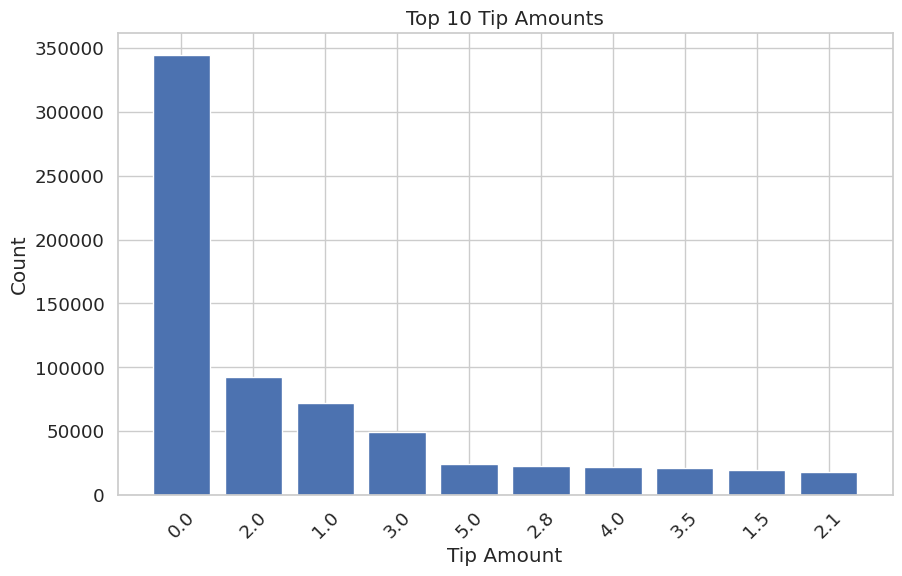

In [51]:
# Grouping by 'tip_amount' and counting occurrences
grouped_df = filtered_pandas_df.groupby('tip_amount').size().reset_index(name='count')

# Sorting by count in descending order and keeping the top 10
top_10 = grouped_df.sort_values(by='count', ascending=False).head(10)

# Plotting the top 10
plt.figure(figsize=(10, 6))
plt.bar(top_10['tip_amount'].astype(str), top_10['count'])
plt.xlabel('Tip Amount')
plt.ylabel('Count')
plt.title('Top 10 Tip Amounts')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

# # Prepare the data for linear regression
# X_fare = filtered_pandas_df[['fare_amount']]
# X_total = filtered_pandas_df[['total_amount']]
# y = filtered_pandas_df['tip_amount']

# # Initialize Linear Regression model
# model = LinearRegression()

# # Fit the model and predict for fare_amount
# model.fit(X_fare, y)
# y_pred_fare = model.predict(X_fare)
# mse_fare = mean_squared_error(y, y_pred_fare)

# # Fit the model and predict for total_amount
# model.fit(X_total, y)
# y_pred_total = model.predict(X_total)
# mse_total = mean_squared_error(y, y_pred_total)

# # Print the mean squared errors
# print(f'Mean Squared Error for Fare Amount vs Tip Amount: {mse_fare:.2f}')
# print(f'Mean Squared Error for Total Amount vs Tip Amount: {mse_total:.2f}')

In [ ]:
# # Plot the correlation between fare_amount and tip_amount
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='fare_amount', y='tip_amount', data=filtered_pandas_df, alpha=0.5, label='Data')
# plt.plot(X_fare, y_pred_fare, color='red', label='Trend Line')
# plt.title('Fare Amount vs Tip Amount')
# plt.xlabel('Fare Amount')
# plt.ylabel('Tip Amount')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plot the correlation between total_amount and tip_amount
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='total_amount', y='tip_amount', data=filtered_pandas_df, alpha=0.5, label='Data')
# plt.plot(X_total, y_pred_total, color='red', label='Trend Line')
# plt.title('Total Amount vs Tip Amount')
# plt.xlabel('Total Amount')
# plt.ylabel('Tip Amount')
# plt.grid(True)
# plt.legend()
# plt.show()

## 2. Trip Duration vs. Distance

In [58]:
# Calculate the time difference in seconds using unix_timestamp
sampled_df = sampled_df.withColumn(
    "trip_duration_seconds",
    unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))
)

# filter using quantile range function based on time_difference_seconds
filtered_df = filter_quantile_range(sampled_df, ["trip_duration_seconds", "trip_distance"], 0.05, 0.95)

In [59]:
pandas_df = filtered_df.select("trip_distance", "trip_duration_seconds").toPandas()

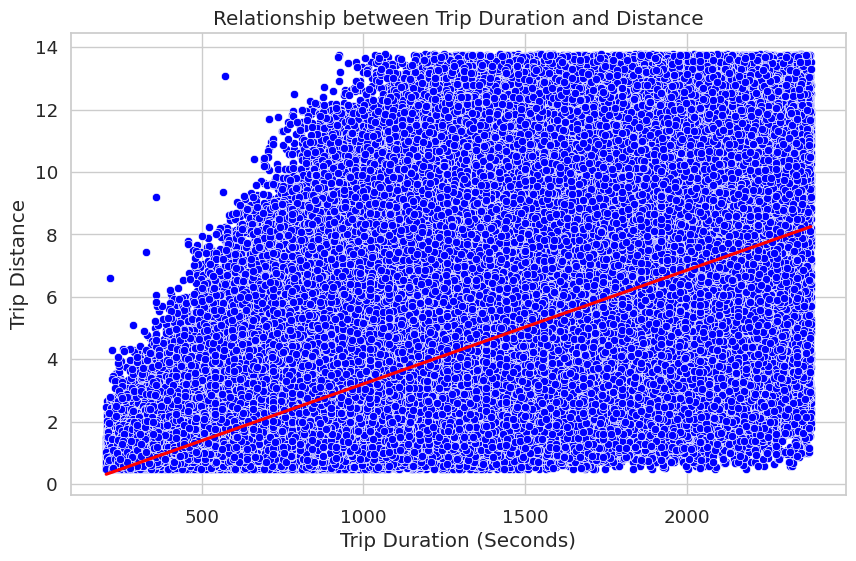

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, color='blue')
sns.regplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, scatter=False, color='red', ci=None)
plt.title("Relationship between Trip Duration and Distance")
plt.xlabel("Trip Duration (Seconds)")
plt.ylabel("Trip Distance")
plt.grid(True)
plt.show()


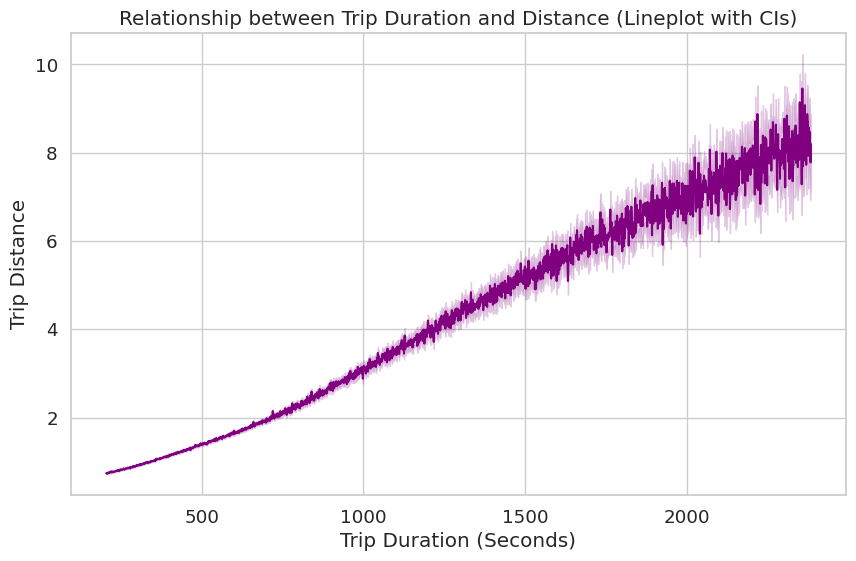

In [63]:
# As the trip duration increases, the trip distance also tends to increase.
plt.figure(figsize=(10, 6))
sns.lineplot(x='trip_duration_seconds', y='trip_distance', data=pandas_df, color='purple')
plt.title("Relationship between Trip Duration and Distance (Lineplot with CIs)")
plt.xlabel("Trip Duration (Seconds)")
plt.ylabel("Trip Distance")
plt.grid(True)
plt.show()

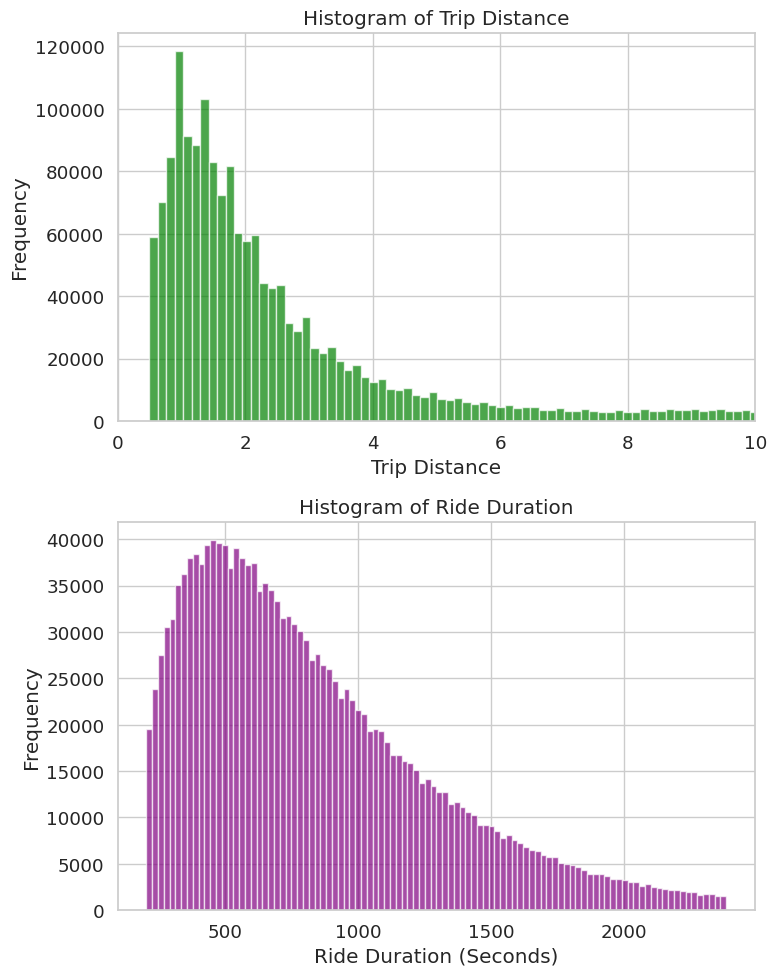

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Histogram for trip distance
axs[0].hist(pandas_df["trip_distance"], bins=100,  color='green', alpha=0.7)
axs[0].set_title('Histogram of Trip Distance')
axs[0].set_xlabel('Trip Distance')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 10)
axs[0].grid(True)

# Histogram for ride duration
axs[1].hist(pandas_df["trip_duration_seconds"], bins=100, color='purple', alpha=0.7)
axs[1].set_title('Histogram of Ride Duration')
axs[1].set_xlabel('Ride Duration (Seconds)')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 3. Trends by hour of day

In [66]:
sampled_df_time = sampled_df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime"))
sampled_df_time = sampled_df_time.withColumn("year", year("tpep_pickup_datetime")) \
       .withColumn("month", month("tpep_pickup_datetime")) \
       .withColumn("day", dayofmonth("tpep_pickup_datetime")) \
       .withColumn("hour", hour("tpep_pickup_datetime")) \
       .withColumn("minute", minute("tpep_pickup_datetime")) \
       .withColumn("second", second("tpep_pickup_datetime"))

# sampled_df_time.show()

In [67]:
pandas_time_df = sampled_df_time.select("year","month","day","hour","minute","second","Extra","fare_amount", "trip_distance").toPandas()
pandas_time_df['Amount_per_Distance'] = pandas_time_df["fare_amount"]/pandas_time_df["trip_distance"]
pandas_time_df

,year,month,day,hour,minute,second,Extra,fare_amount,trip_distance,Amount_per_Distance
0,2023,1,1,0,27,12,1.0,45.70,11.70,3.905983
1,2023,1,1,0,34,44,1.0,26.10,3.23,8.080495
2,2023,1,1,0,31,41,1.0,17.00,1.18,14.406780
3,2023,1,1,0,30,31,1.0,16.30,2.32,7.025862
4,2023,1,1,0,20,24,3.5,5.10,0.20,25.500000
...,...,...,...,...,...,...,...,...,...,...
1949429,2023,6,30,23,30,28,0.0,36.21,9.78,3.702454
1949430,2023,6,30,23,7,30,0.0,30.33,3.66,8.286885
1949431,2023,6,30,23,36,40,0.0,26.09,5.18,5.036680
1949432,2023,6,30,23,58,57,0.0,34.83,9.54,3.650943


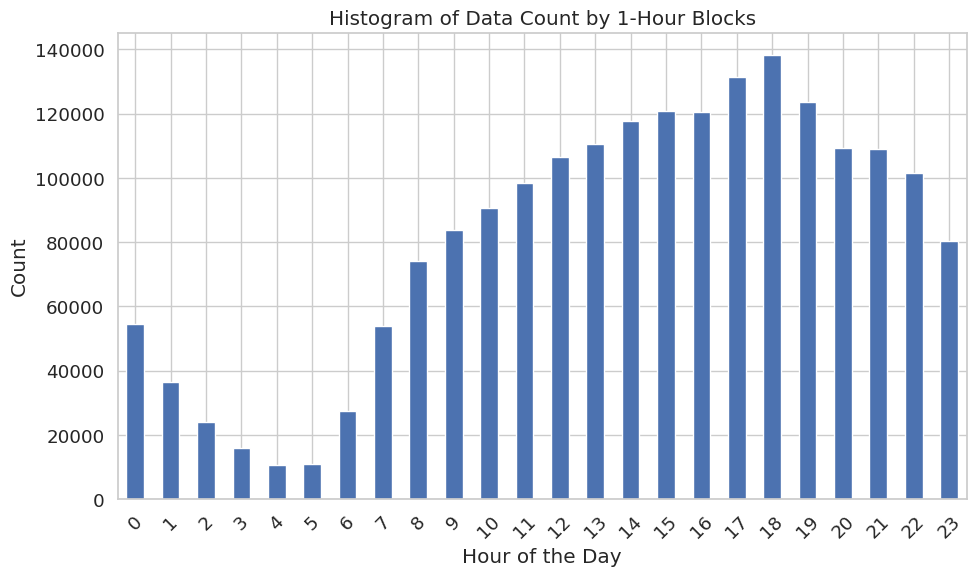

In [68]:
time_block_counts = pandas_time_df.groupby('hour').size()

plt.figure(figsize=(10, 6))
time_block_counts.plot(kind='bar')
plt.title('Histogram of Data Count by 1-Hour Blocks')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

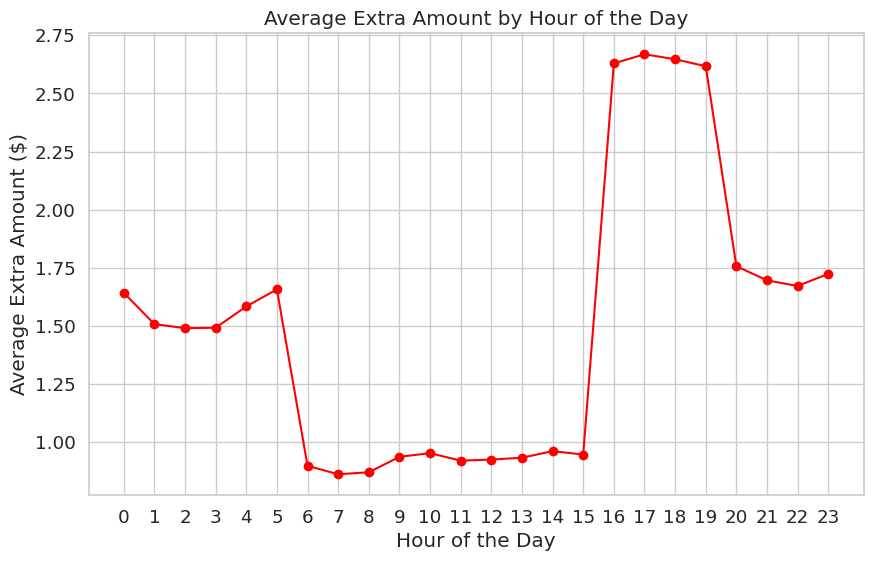

In [69]:
hourly_avg = pandas_time_df.groupby('hour')['Extra'].mean()

plt.figure(figsize=(10, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', color='red')
plt.title('Average Extra Amount by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Extra Amount ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

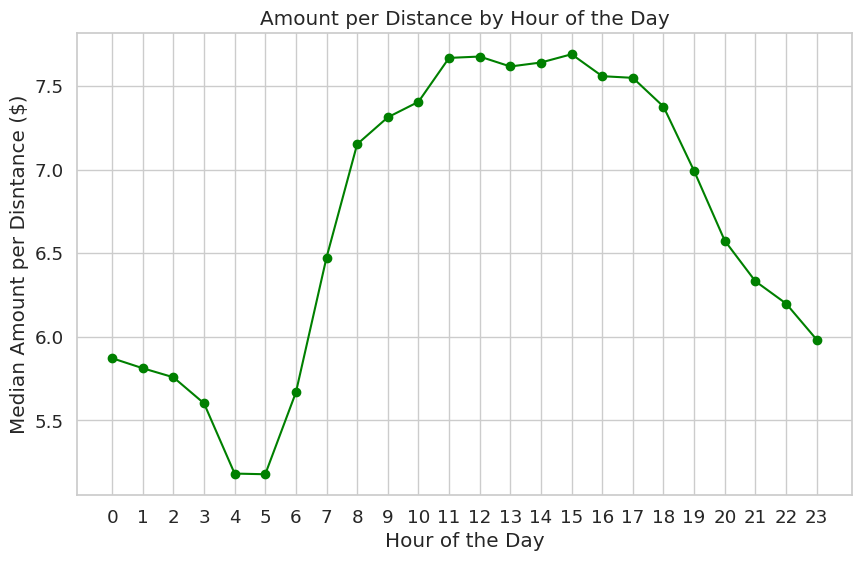

In [70]:
avg = pandas_time_df.groupby('hour')['Amount_per_Distance'].median()

plt.figure(figsize=(10, 6))
plt.plot(avg.index, avg.values, marker='o', color='green')
plt.title('Amount per Distance by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Median Amount per Disntance ($)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

## 4. Distribution of Payment Type by Locations & Months

+------------+------------+------+
|PULocationID|payment_type| count|
+------------+------------+------+
|         236|           1|678126|
|         175|           2|    80|
|         255|           3|    66|
|         195|           4|    23|
|           3|           0|    10|
|         256|           4|   106|
|          95|           2|   556|
|         146|           0|   710|
|         212|           1|   341|
|          80|           3|    69|
|         256|           1|  3555|
|         136|           1|   680|
|         214|           3|     1|
|         253|           2|    16|
|         243|           4|    69|
|          44|           3|    11|
|          88|           0|  1870|
|         226|           2|  5006|
|          39|           3|    28|
|         139|           2|    34|
+------------+------------+------+
only showing top 20 rows

+------------+------------+------+
|DOLocationID|payment_type| count|
+------------+------------+------+
|         236|           1|72

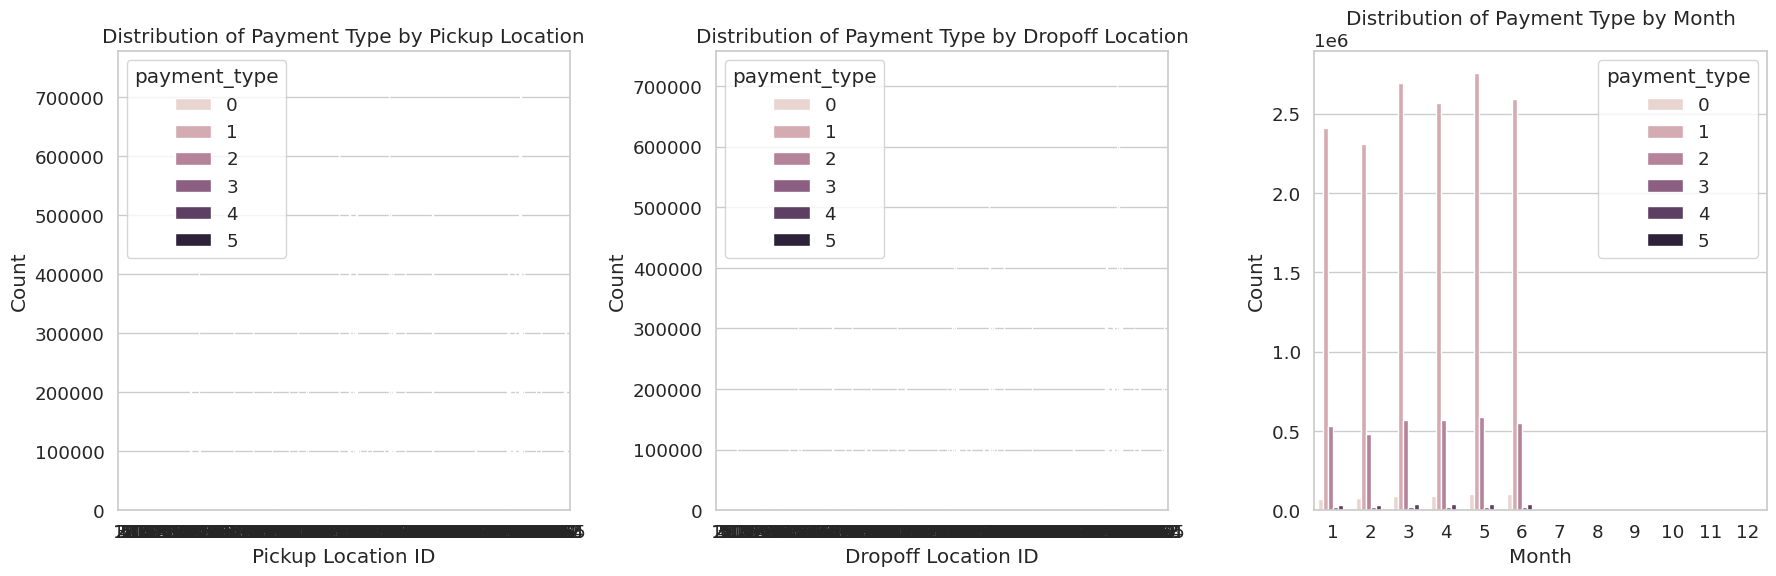

In [71]:
# Distribution of Payment_type by Pickup Location
pickup_location_distribution = df.groupBy("PULocationID", "payment_type").count()

# Distribution of Payment_type by Dropoff Location
dropoff_location_distribution = df.groupBy("DOLocationID", "payment_type").count()

# Distribution of Payment_type by Month
month_distribution = df.withColumn("month", mzzonth("tpep_pickup_datetime")) \
    .groupBy("month", "payment_type").count()

# Show the distributions
pickup_location_distribution.show()
dropoff_location_distribution.show()
month_distribution.show()

# Plotting the distributions
plt.figure(figsize=(18, 6))

# Distribution by Pickup Location
plt.subplot(1, 3, 1)
sns.barplot(x="PULocationID", y="count", hue="payment_type", data=pickup_location_distribution.toPandas())
plt.title('Distribution of Payment Type by Pickup Location')
plt.xlabel('Pickup Location ID')
plt.ylabel('Count')

# Distribution by Dropoff Location
plt.subplot(1, 3, 2)
sns.barplot(x="DOLocationID", y="count", hue="payment_type", data=dropoff_location_distribution.toPandas())
plt.title('Distribution of Payment Type by Dropoff Location')
plt.xlabel('Dropoff Location ID')
plt.ylabel('Count')

# Distribution by Month
plt.subplot(1, 3, 3)
sns.barplot(x="month", y="count", hue="payment_type", data=month_distribution.toPandas())
plt.title('Distribution of Payment Type by Month')
plt.xlabel('Month')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [73]:
df.withColumn("month", month("tpep_pickup_datetime")) \
    .groupBy("month").count().show()

+-----+-------+
|month|  count|
+-----+-------+
|   12|     47|
|    1|3066740|
|   10|     11|
|    2|2914003|
|    3|3403660|
|    4|3288248|
|   11|      1|
|    5|3513664|
|    6|3307218|
|    9|      1|
|    8|      2|
|    7|     25|
+-----+-------+



## 6. Visualizations on the map

## 6. Visualizations on the map

In [141]:
loc = pd.read_csv('yellow_taxi_data/taxi_zone_lookup.csv')

In [142]:
pudf = df.select('PULocationID','DOLocationID').cache()

In [143]:
schema = StructType([
StructField("LocationID", StringType(), True),
StructField("Borough", StringType(), True),
StructField("Zone", StringType(), True),
StructField("service_zone", StringType(), True)])

locdf = spark.createDataFrame(loc, schema)

In [144]:
## Pickup Location

In [145]:
merged_doLoc = pudf.join(locdf, pudf.PULocationID == locdf.LocationID, how = 'left')
loc_grouped = merged_doLoc.groupBy(['service_zone','Borough','Zone']).count().orderBy('count', ascending = False).toPandas()
zone = gpd.read_file("yellow_taxi_data/taxi_zones/taxi_zones.shp")
map_df = zone.merge(loc_grouped, left_on = 'zone', right_on ='Zone' )
map_df['center'] = map_df.representative_point()

Text(113.00518163317493, 0.5, 'Latitude')

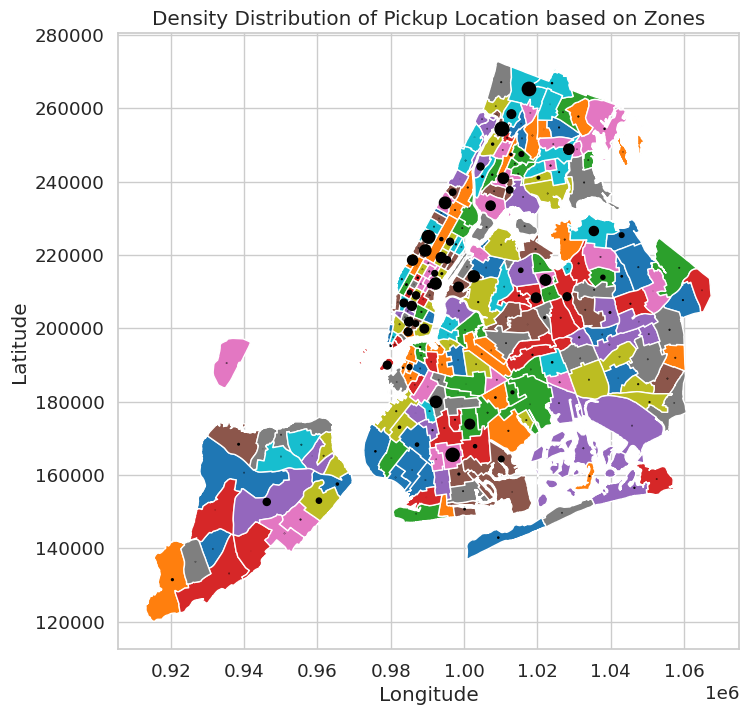

In [146]:
# Plotting the density of dropoff for each 'zone' 

map_df_dissolved_count = map_df.dissolve(by='zone', aggfunc={'count': 'sum'}).reset_index()
ax = map_df_dissolved_count.plot(figsize=(10, 8), column='zone', legend=False)

map_df_dissolved_count['center'] = map_df_dissolved_count.representative_point()
map_df_dissolved_count.rename(columns={'geometry': 'x1', 'center': 'geometry'})\
        .plot(ax=ax, marker='o', color='black', markersize=1*(map_df['count']/10000))

ax.set_title('Density Distribution of Pickup Location based on Zones')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Text(113.00518163317493, 0.5, 'Latitude')

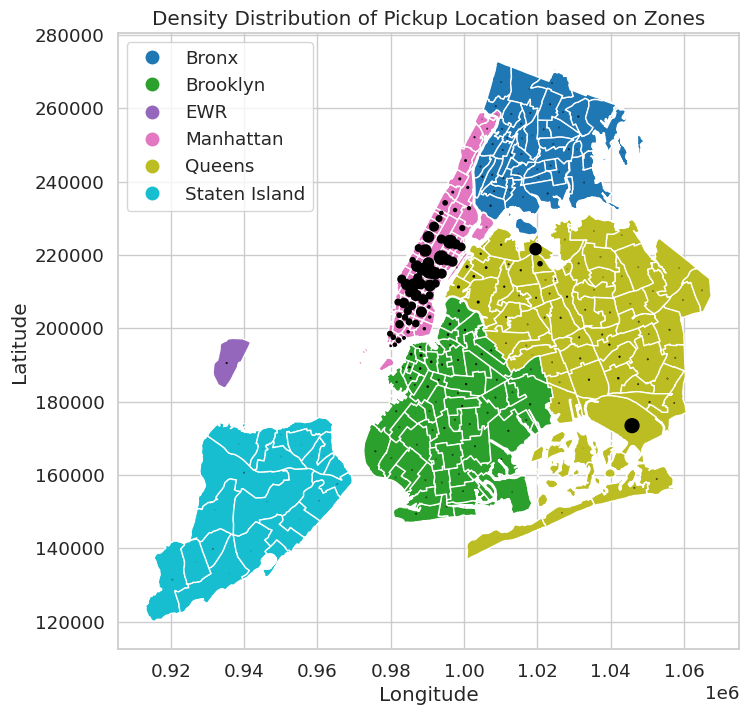

In [147]:
#choose either the above or below part
ny = zone.plot(column='borough', legend=True, figsize=(10, 8))
map_df.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=ny, marker='o', color='black', markersize = 1*(map_df['count']/10000))
ny.set_title('Density Distribution of Pickup Location based on Zones')
ny.set_xlabel('Longitude')
ny.set_ylabel('Latitude')


Text(113.00518163317493, 0.5, 'Latitude')

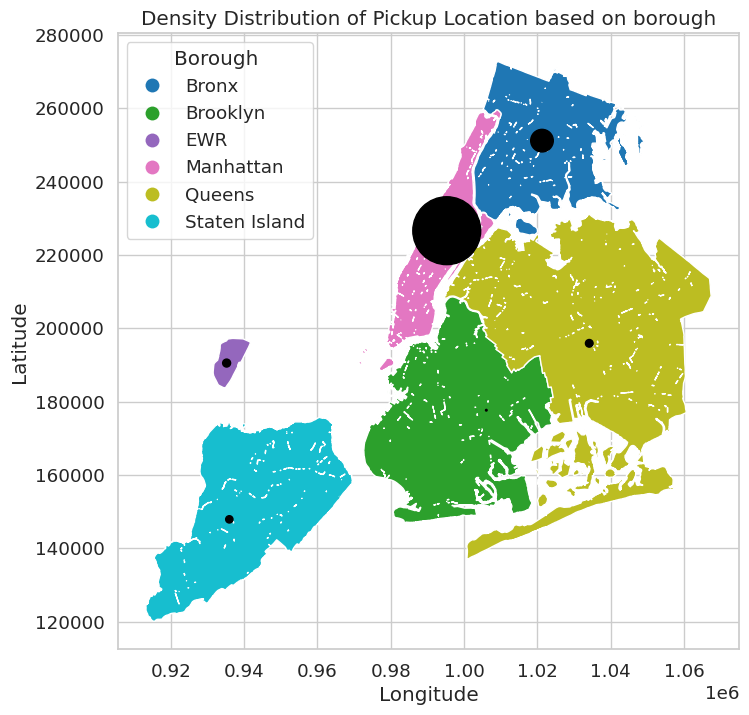

In [151]:
# Plotting the density of dropoff location for each 'borough' 
# Airports and Yellow Zone have the highest booking; Boro Zone and EWR contribution to pickup location are negligible
map_df_dissolved_count = map_df.dissolve(by='borough', aggfunc={'count': 'sum'}).reset_index()
ax = map_df_dissolved_count.plot(figsize=(10, 8), column='borough', legend=True, legend_kwds={'title': 'Borough ', 'loc': 'upper left'})
map_df_dissolved_count['center'] = map_df_dissolved_count.representative_point()
map_df_dissolved_count.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=ax, marker='o', color='black', markersize = 1*(map_df['count']/10))
ax.set_title('Density Distribution of Pickup Location based on borough')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


Text(113.00518163317493, 0.5, 'Latitude')

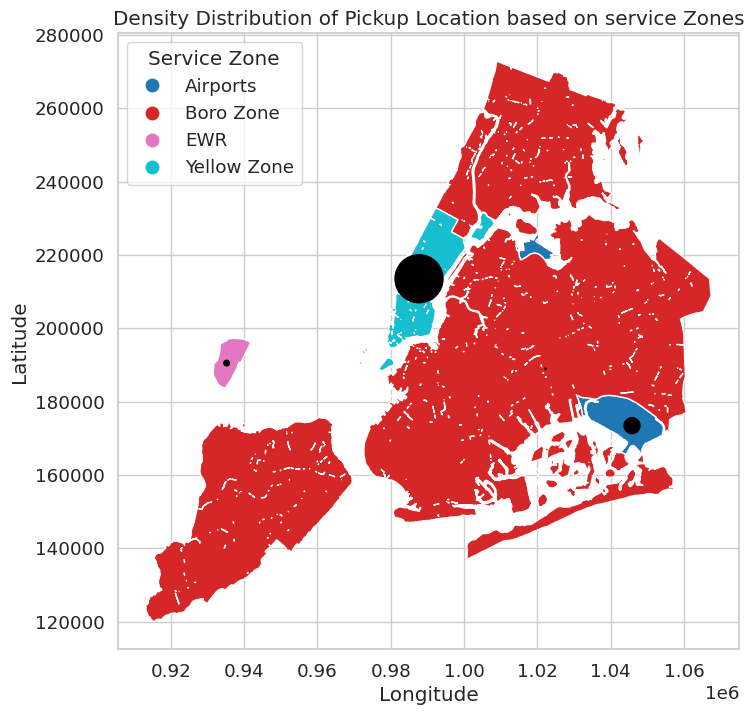

In [148]:
# Plotting the density of dropoff location for each 'service_zone' 
# Airports and Yellow Zone have the highest booking; Boro Zone and EWR contribution to pickup location are negligible
map_df_dissolved_count = map_df.dissolve(by='service_zone', aggfunc={'count': 'sum'}).reset_index()
ax = map_df_dissolved_count.plot(figsize=(10, 8), column='service_zone', legend=True, legend_kwds={'title': 'Service Zone', 'loc': 'upper left'})
map_df_dissolved_count['center'] = map_df_dissolved_count.representative_point()
map_df_dissolved_count.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=ax, marker='o', color='black', markersize = 1*(map_df['count']/20))
ax.set_title('Density Distribution of Pickup Location based on service Zones')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


# Dropoff Location

In [153]:
merged_doLoc = pudf.join(locdf, pudf.DOLocationID == locdf.LocationID, how = 'left')
loc_grouped = merged_doLoc.groupBy(['service_zone','Borough','Zone']).count().orderBy('count', ascending = False).toPandas()
zone = gpd.read_file("yellow_taxi_data/taxi_zones/taxi_zones.shp")
map_df = zone.merge(loc_grouped, left_on = 'zone', right_on ='Zone' )
map_df['center'] = map_df.representative_point()

Text(113.00518163317493, 0.5, 'Latitude')

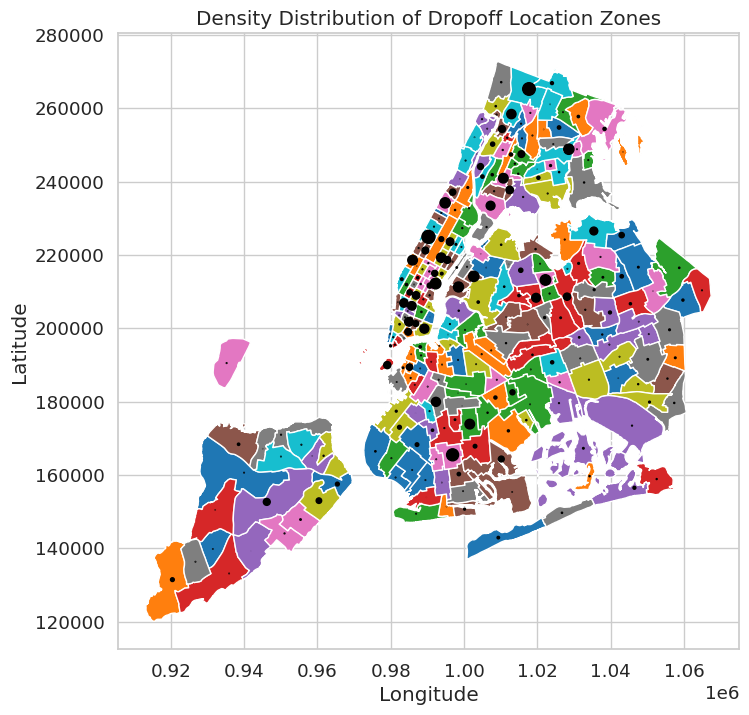

In [154]:
# Plotting the density of dropoff for each 'zone' 

map_df_dissolved_count = map_df.dissolve(by='zone', aggfunc={'count': 'sum'}).reset_index()
ax = map_df_dissolved_count.plot(figsize=(10, 8), column='zone', legend=False)

map_df_dissolved_count['center'] = map_df_dissolved_count.representative_point()
map_df_dissolved_count.rename(columns={'geometry': 'x1', 'center': 'geometry'})\
        .plot(ax=ax, marker='o', color='black', markersize=1*(map_df['count']/10000))

ax.set_title('Density Distribution of Dropoff Location Zones')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


Text(113.00518163317493, 0.5, 'Latitude')

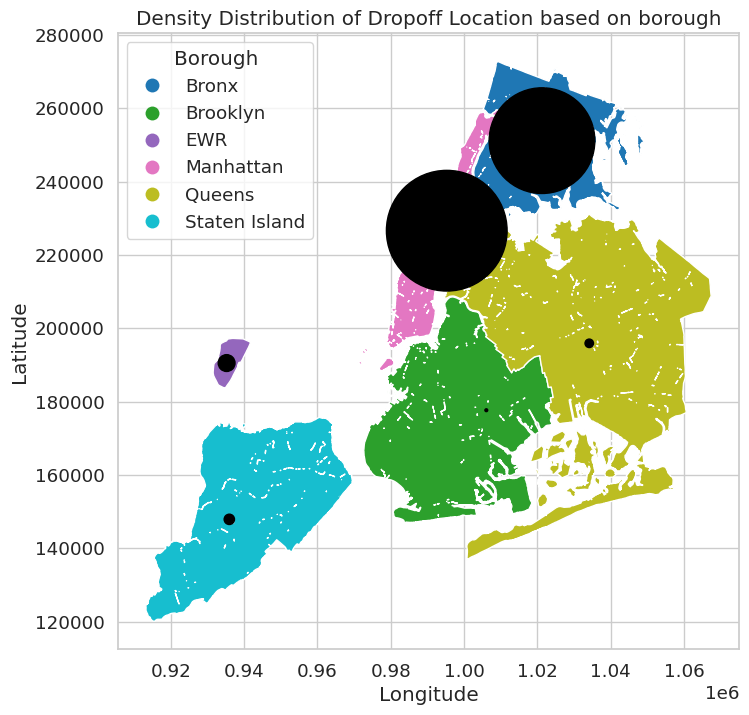

In [157]:
# Plotting the density of dropoff location for each 'borough' 

#compared to the pickup location density, we can see that bronx brough has a lot more pickups. 

map_df_dissolved_count = map_df.dissolve(by='borough', aggfunc={'count': 'sum'}).reset_index()
ax = map_df_dissolved_count.plot(figsize=(10, 8), column='borough', legend=True, legend_kwds={'title': 'Borough ', 'loc': 'upper left'})
map_df_dissolved_count['center'] = map_df_dissolved_count.representative_point()
map_df_dissolved_count.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=ax, marker='o', color='black', markersize = 1*(map_df['count']/10))
ax.set_title('Density Distribution of Dropoff Location based on borough')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Text(113.00518163317493, 0.5, 'Latitude')

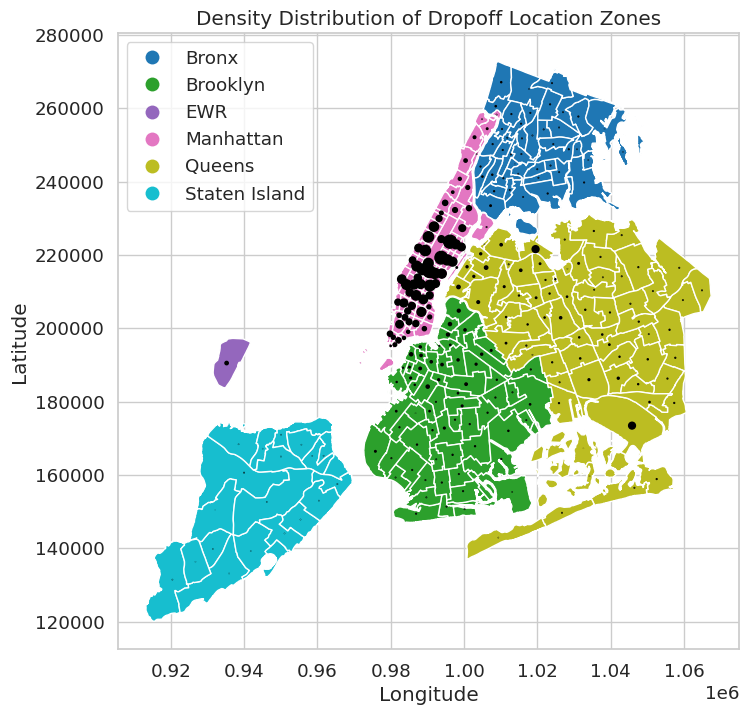

In [156]:
#choose either the above or below part
ny = zone.plot(column='borough', legend=True, figsize=(10, 8))
map_df.rename(columns = {'geometry': 'x1','center':'geometry'}).plot(ax=ny, marker='o', color='black', markersize = 1*(map_df['count']/10000))
ny.set_title('Density Distribution of Dropoff Location Zones')
ny.set_xlabel('Longitude')
ny.set_ylabel('Latitude')